In [2]:
import json
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.text import tokenizer_from_json

sys.path.insert(0, os.path.abspath("../"))
from data.data import DatasetLoader

2025-11-26 00:36:44.118936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 00:36:44.172538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 00:36:45.122468: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
def add_text_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add basic text length features used in the analysis."""
    enriched = df.copy()
    enriched["prompt_word_len"] = enriched["prompt"].str.split().str.len()
    enriched["prompt_char_len"] = enriched["prompt"].str.len()
    enriched["negative_prompt_word_len"] = (
        enriched["negativePrompt"].str.split().str.len()
    )
    enriched["negative_prompt_char_len"] = enriched["negativePrompt"].str.len()
    enriched["has_negative_prompt"] = enriched["negativePrompt"].str.strip().ne("")
    return enriched

In [4]:
loader = DatasetLoader()
df = loader.load()
df = add_text_features(df)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d28e2dba-c393-4b3c-84c2-b1ead70118d9)')' thrown while requesting HEAD https://huggingface.co/datasets/thefcraft/civitai-stable-diffusion-337k/resolve/main/README.md
Retrying in 1s [Retry 1/5].


In [5]:
df

,prompt,negativePrompt,nsfw,prompt_word_len,prompt_char_len,negative_prompt_word_len,negative_prompt_char_len,has_negative_prompt
0,"hiqcgbody, hiqcgface, 1girl, full body, standi...","EasyNegative, extra fingers, fewer fingers, mu...",True,23,186,9,74,True
1,"masterpiece, best quality, highres, absurdres,...","EasyNegative, extra fingers, fewer fingers",True,21,187,5,42,True
2,"masterpiece, best quality, highres, absurdres,...","EasyNegative, extra fingers, fewer fingers, mo...",True,26,217,6,54,True
3,"20 year old k-idol, legs spread on cock:1.4, g...","blurry, pubic hair:2, animated, cartoon, dupli...",True,78,546,28,230,True
4,"8k, RAW photo, best quality, masterpiece:1.2, ...","EasyNegative, paintings, sketches, worst quali...",True,42,349,26,212,True
...,...,...,...,...,...,...,...,...
273283,"samdoesarts style woman by agnes cecile, lumin...","cartoon, disfigured, bad art, deformed, poorly...",False,14,98,15,102,True
273284,samdoesarts style symmetry:1.1 portrait of flo...,"cartoon, disfigured, bad art, deformed, poorly...",False,43,337,15,102,True
273285,samdoesarts style symmetry:1.1 portrait of flo...,"cartoon, disfigured, bad art, deformed, poorly...",False,43,337,15,102,True
273286,samdoesarts style symmetry:1.1 portrait of flo...,"cartoon, disfigured, bad art, deformed, poorly...",False,43,337,15,102,True


## Label distribution

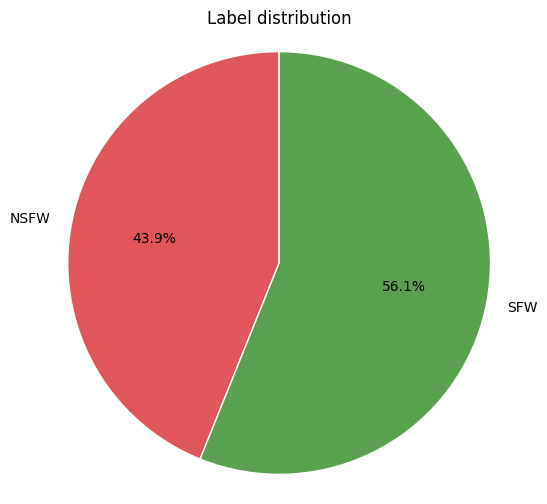

In [6]:
label_counts = df["nsfw"].value_counts(dropna=False)
counts = [label_counts.get(True, 0), label_counts.get(False, 0)]
labels = ["NSFW", "SFW"]
colors = ["#e15759", "#59a14f"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
)
ax.set_title("Label distribution")
ax.axis("equal")  # equal aspect ratio to ensure a circle
plt.show()

## Token length distribution
Token counts of concatenated prompt + negativePrompt using the project's tokenizer; capped at the 99th percentile to focus on the main mass of samples.

In [7]:
with open("../nsfw_prompt_detection_sd/tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_data = json.load(f)
    tokenizer = tokenizer_from_json(json.dumps(tokenizer_data))

# Join prompt and negative prompt, collapse whitespace
full_prompt = (
    df["prompt"]
    .fillna("")
    .str.strip()
    .str.cat(df["negativePrompt"].fillna("").str.strip(), sep=" ")
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Count tokens using the loaded tokenizer
sequences = tokenizer.texts_to_sequences(full_prompt.tolist())
df["token_len"] = [len(seq) for seq in sequences]

In [8]:
df

,prompt,negativePrompt,nsfw,prompt_word_len,prompt_char_len,negative_prompt_word_len,negative_prompt_char_len,has_negative_prompt,token_len
0,"hiqcgbody, hiqcgface, 1girl, full body, standi...","EasyNegative, extra fingers, fewer fingers, mu...",True,23,186,9,74,True,32
1,"masterpiece, best quality, highres, absurdres,...","EasyNegative, extra fingers, fewer fingers",True,21,187,5,42,True,26
2,"masterpiece, best quality, highres, absurdres,...","EasyNegative, extra fingers, fewer fingers, mo...",True,26,217,6,54,True,32
3,"20 year old k-idol, legs spread on cock:1.4, g...","blurry, pubic hair:2, animated, cartoon, dupli...",True,78,546,28,230,True,138
4,"8k, RAW photo, best quality, masterpiece:1.2, ...","EasyNegative, paintings, sketches, worst quali...",True,42,349,26,212,True,80
...,...,...,...,...,...,...,...,...,...
273283,"samdoesarts style woman by agnes cecile, lumin...","cartoon, disfigured, bad art, deformed, poorly...",False,14,98,15,102,True,30
273284,samdoesarts style symmetry:1.1 portrait of flo...,"cartoon, disfigured, bad art, deformed, poorly...",False,43,337,15,102,True,65
273285,samdoesarts style symmetry:1.1 portrait of flo...,"cartoon, disfigured, bad art, deformed, poorly...",False,43,337,15,102,True,65
273286,samdoesarts style symmetry:1.1 portrait of flo...,"cartoon, disfigured, bad art, deformed, poorly...",False,43,337,15,102,True,65


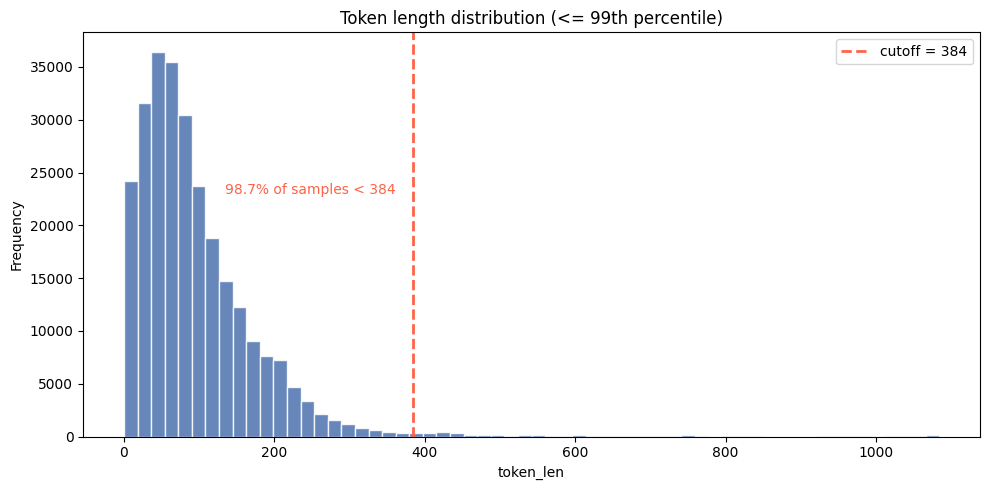

In [9]:
cutoff = 384
token_99 = df["token_len"].quantile(0.99)
filtered_df = df.loc[df["token_len"] <= token_99]
share_below = (filtered_df["token_len"] < cutoff).mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(filtered_df["token_len"], bins=60, color="#4c72b0", alpha=0.85, edgecolor="white")
ax.axvline(cutoff, color="tomato", linestyle="--", linewidth=2, label=f"cutoff = {cutoff}")

ylim = ax.get_ylim()[1]
ax.text(
    cutoff - 250,
    ylim * 0.6,
    f"{share_below*100:.1f}% of samples < {cutoff}",
    color="tomato",
)

ax.set_title("Token length distribution (<= 99th percentile)")
ax.set_xlabel("token_len")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()


## Word clouds by label
Word clouds for NSFW vs SFW, split by prompt and negativePrompt, to surface high-frequency terms per class.

In [10]:
import subprocess
import sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update({"nsfw", "sfw", "negative", "prompt"})

# Concatenate text for each split
def _concat_text(series):
    return " ".join(series.dropna().astype(str))

nsfw_prompt_text = _concat_text(df.loc[df["nsfw"] == True, "prompt"])
sfw_prompt_text = _concat_text(df.loc[df["nsfw"] == False, "prompt"])
nsfw_neg_text = _concat_text(df.loc[df["nsfw"] == True, "negativePrompt"])
sfw_neg_text = _concat_text(df.loc[df["nsfw"] == False, "negativePrompt"])


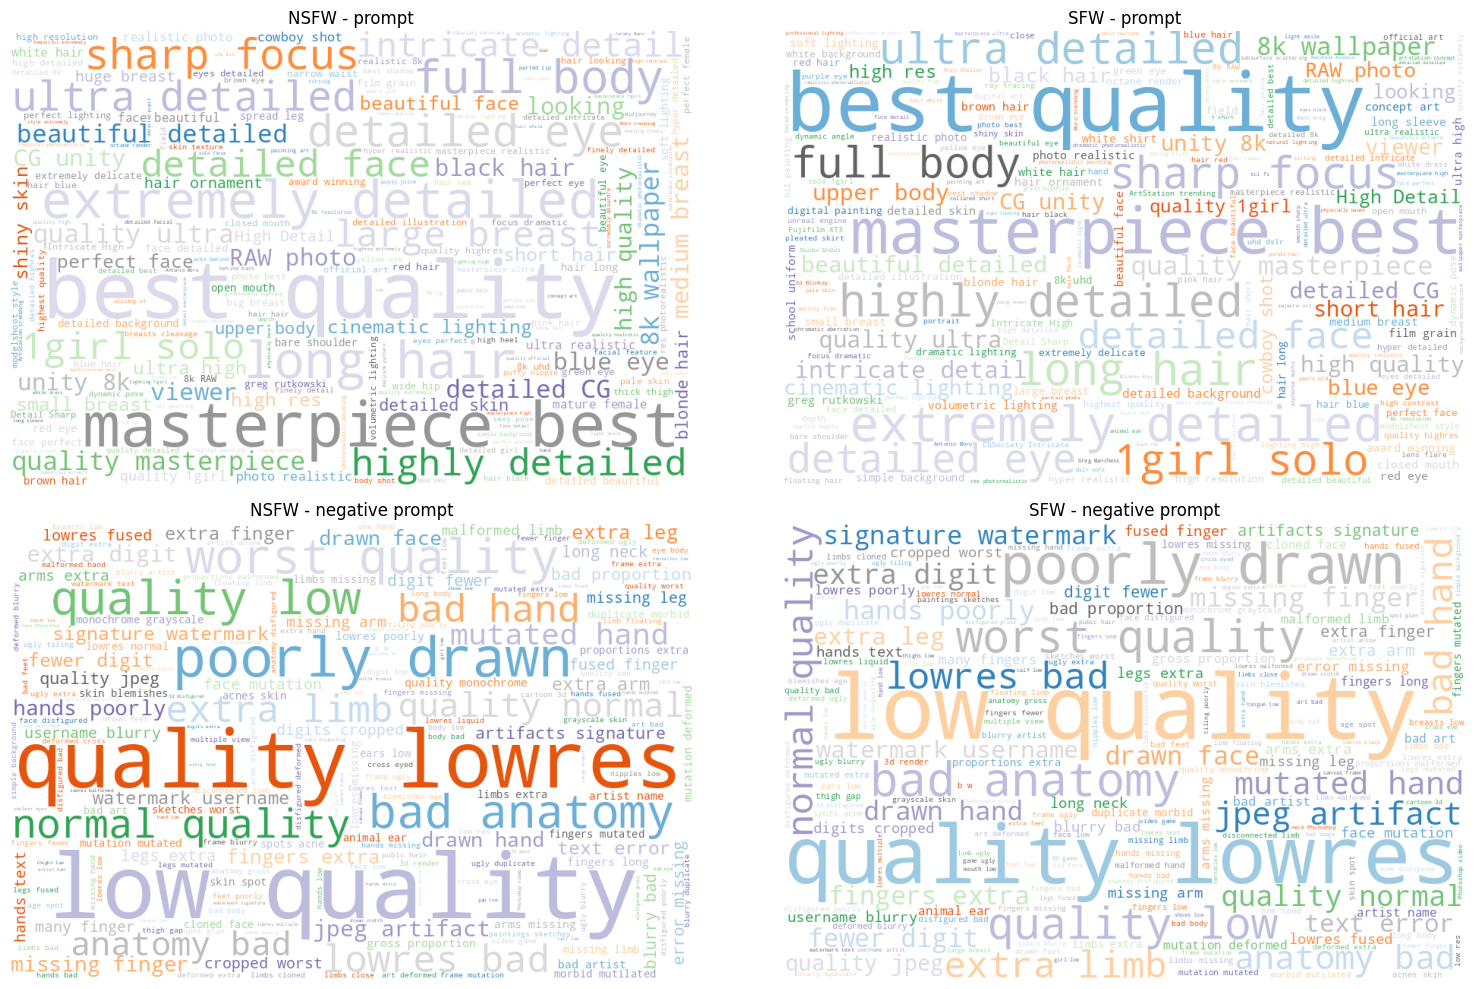

In [11]:
params = dict(
    width=900,
    height=600,
    background_color="white",
    max_words=200,
    stopwords=stopwords,
    colormap="tab20c",
)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].imshow(WordCloud(**params).generate(nsfw_prompt_text))
axes[0, 0].set_title("NSFW - prompt")
axes[0, 0].axis("off")

axes[0, 1].imshow(WordCloud(**params).generate(sfw_prompt_text))
axes[0, 1].set_title("SFW - prompt")
axes[0, 1].axis("off")

axes[1, 0].imshow(WordCloud(**params).generate(nsfw_neg_text))
axes[1, 0].set_title("NSFW - negative prompt")
axes[1, 0].axis("off")

axes[1, 1].imshow(WordCloud(**params).generate(sfw_neg_text))
axes[1, 1].set_title("SFW - negative prompt")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()
